## Tool Calling with Agentic AI - AutoGen

### LLM Used - Granite3.0-8B

In this notebook we will learn how to use Tool Calling with Agentic AI in order to solve different problems.

Tool-calling agents expand the capabilities of an LLM by allowing it to interact with external systems. This approach empowers agents to dynamically solve problems by utilizing tools, accessing memory, and planning multi-step actions.

Tool calling agents enable:

1. Multi-Step Decision Making: The LLM can orchestrate a sequence of decisions to achieve complex objectives.
2. Tool Access: The LLM can select and use various tools as needed to interact with external systems and APIs.

This architecture allows for more dynamic and flexible behaviors, enabling agents to solve complex tasks by leveraging external resources efficiently.

In [1]:
!pip install autogen-agentchat~=0.2 autogen psutil --quiet 
# !pip install -q langchain-openai termcolor langchain_community duckduckgo_search wikipedia openapi-python-client==0.12.3 langgraph langchain_experimental yfinance
!pip install -q langchain-openai termcolor langchain_community duckduckgo_search wikipedia openapi-python-client langgraph langchain_experimental openai --quiet
!pip install -U docker --quiet 


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import autogen
from typing import Literal

from pydantic import BaseModel, Field
from typing_extensions import Annotated

import autogen
from autogen.cache import Cache

INFERENCE_SERVER_URL = "http://localhost:8000"
MODEL_NAME = "ibm-granite/granite-3.0-8b-instruct"
API_KEY= "alanliuxiang"


Patching name='PARAMS_MAPPING', member={'max_tokens': 'max_output_tokens', 'stop_sequences': 'stop_sequences', 'temperature': 'temperature', 'top_p': 'top_p', 'top_k': 'top_k', 'max_output_tokens': 'max_output_tokens'}, patched={'max_tokens': 'max_output_tokens', 'stop_sequences': 'stop_sequences', 'temperature': 'temperature', 'top_p': 'top_p', 'top_k': 'top_k', 'max_output_tokens': 'max_output_tokens'}
Patching name='__init__', member=<function GeminiClient.__init__ at 0x7f75e03be480>, patched=<function function.__call__ at 0x7f75e03bede0>
Patching name='_concat_parts', member=<function GeminiClient._concat_parts at 0x7f75e03be840>, patched=<function function.__call__ at 0x7f75e03bee80>
Patching name='_convert_json_response', member=<function GeminiClient._convert_json_response at 0x7f75e03be980>, patched=<function function.__call__ at 0x7f75e03bef20>
Patching name='_create_gemini_function_declaration', member=<function GeminiClient._create_gemini_function_declaration at 0x7f75e03bea

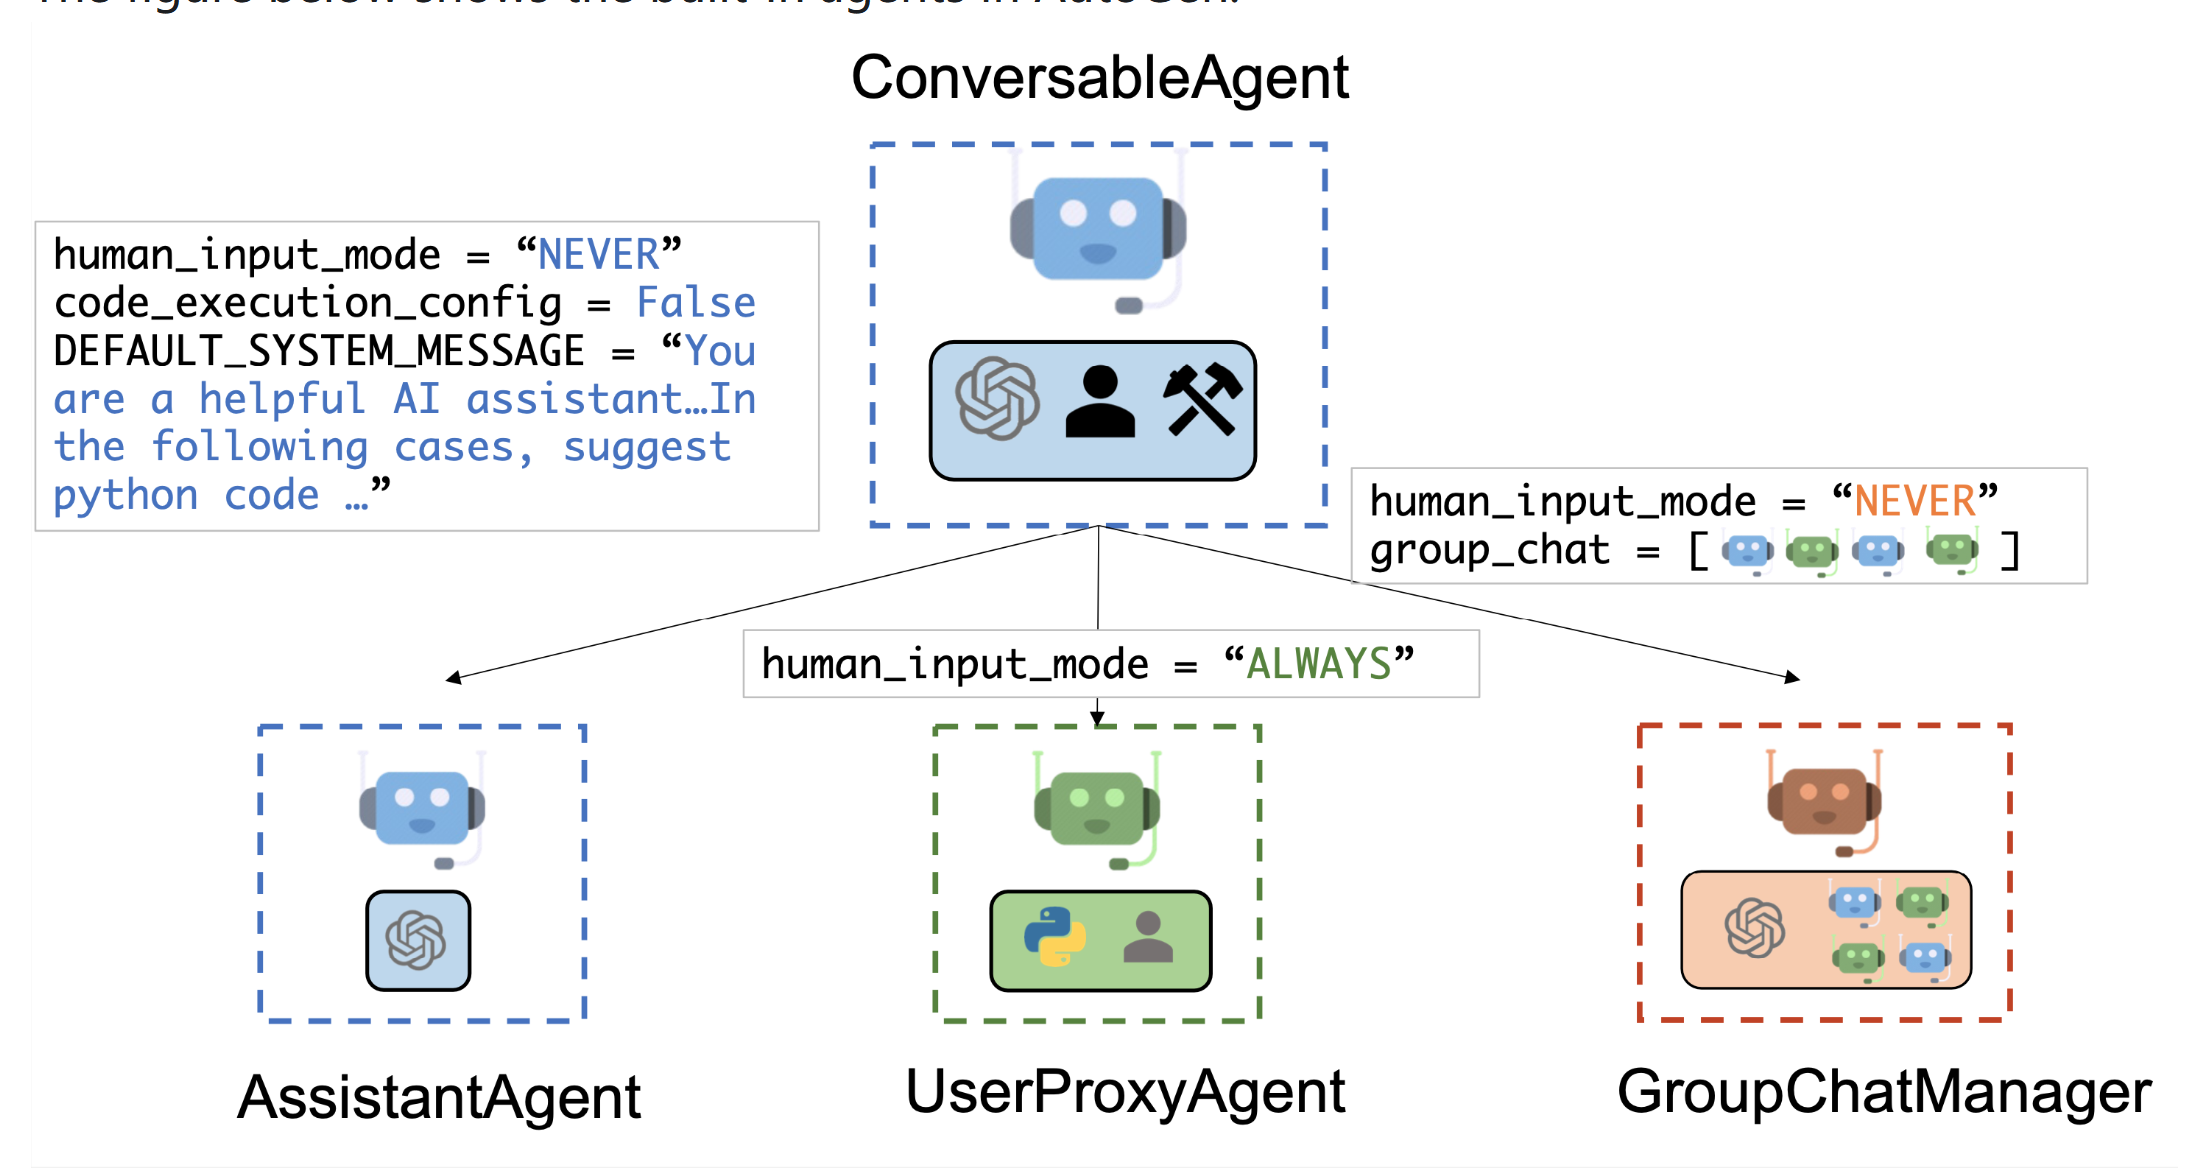

In [3]:
# Configuration for the vLLM endpoint
local_llm_config = {
    "config_list": [
        {
            "model": MODEL_NAME,
            "api_key": API_KEY,
            "base_url": f"{INFERENCE_SERVER_URL}/v1"
        }
    ],
    "cache_seed": None,
    "temperature": 0.01,
    "timeout": 600,
}

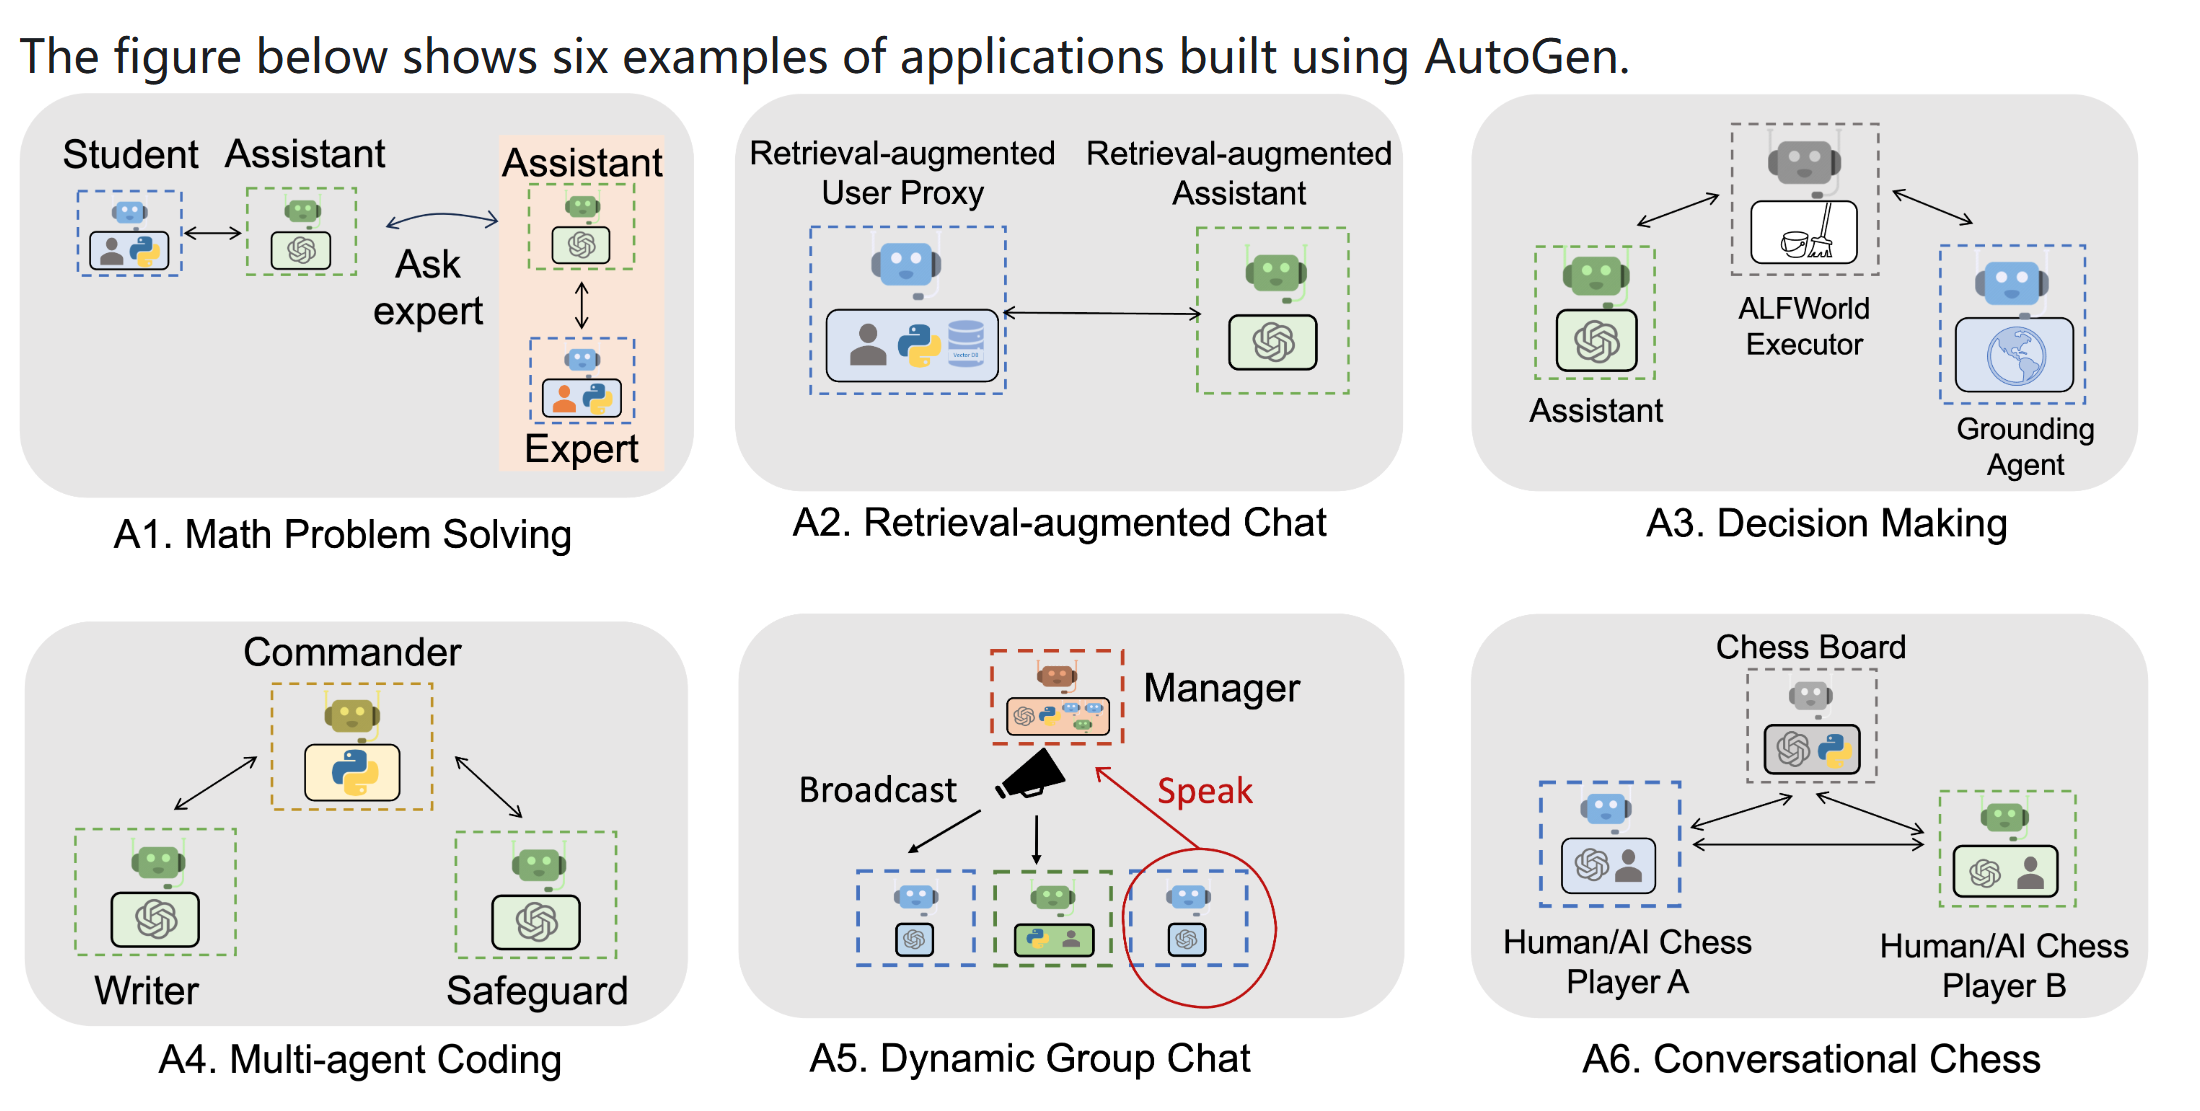

In [4]:
import os
from autogen import AssistantAgent, UserProxyAgent
from autogen.coding import DockerCommandLineCodeExecutor

assistant = AssistantAgent(
    name="code_writer_agent",
    llm_config=local_llm_config,
    code_execution_config=False,#这个ageent 只会代理只会提出(propose 计划，建议)代码，而不会执行它们。
    human_input_mode="NEVER",
)

# create a UserProxyAgent instance named "user_proxy" with code execution on docker.
# code_executor = DockerCommandLineCodeExecutor()
# user_proxy = UserProxyAgent(name="user_proxy",
#                             code_execution_config={"executor": code_executor})


# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("TERMINATE"),
    human_input_mode="NEVER",
    # max_consecutive_auto_reply=10,
    max_consecutive_auto_reply=6,
    code_execution_config={
        "last_n_messages": 2,
        "work_dir": "groupchat",
        "use_docker": False,
    },
)

In [5]:
# the assistant receives a message from the user, which contains the task description
user_proxy.initiate_chat(
    assistant,
    message="""What date is today? Which big tech stock has the largest year-to-date gain this year? How much is the gain?""",
)

user_proxy (to code_writer_agent):

What date is today? Which big tech stock has the largest year-to-date gain this year? How much is the gain?

--------------------------------------------------------------------------------
[autogen.oai.client: 01-29 08:42:47] {521} WARNING - Model ibm-granite/granite-3.0-8b-instruct is not found. The cost will be 0. In your config_list, add field {"price" : [prompt_price_per_1k, completion_token_price_per_1k]} for customized pricing.
code_writer_agent (to user_proxy):

1. To get the current date, we can use the `datetime` module in Python.

```python
from datetime import date

today = date.today()
print("Today's date is:", today)
```

2. To find out which big tech stock has the largest year-to-date gain, we can use the `yfinance` library in Python to fetch the stock data.

```python
import yfinance as yf

# List of big tech stocks
stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'FB']

# Initialize variables to store the stock symbol and its YTD gain
max_

ChatResult(chat_id=None, chat_history=[{'content': 'What date is today? Which big tech stock has the largest year-to-date gain this year? How much is the gain?', 'role': 'assistant', 'name': 'user_proxy'}, {'content': '1. To get the current date, we can use the `datetime` module in Python.\n\n```python\nfrom datetime import date\n\ntoday = date.today()\nprint("Today\'s date is:", today)\n```\n\n2. To find out which big tech stock has the largest year-to-date gain, we can use the `yfinance` library in Python to fetch the stock data.\n\n```python\nimport yfinance as yf\n\n# List of big tech stocks\nstocks = [\'AAPL\', \'GOOGL\', \'MSFT\', \'AMZN\', \'FB\']\n\n# Initialize variables to store the stock symbol and its YTD gain\nmax_stock = \'\'\nmax_gain = 0\n\n# Loop through each stock\nfor stock in stocks:\n    # Fetch the stock data\n    stock_data = yf.download(stock, start=\'2022-01-01\', end=today.strftime(\'%Y-%m-%d\'))\n\n    # Calculate the YTD gain\n    ytd_gain = (stock_data[\'Cl